# Problem House pricing piecewise linear regression



### load dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

dftrain = pd.read_csv("../datasets/house_price_csv/train.csv",index_col='ad_id')
dftest  = pd.read_csv( "../datasets/house_price_csv/test.csv",index_col='ad_id')
dfyte=pd.read_csv("../datasets/house_price_csv/true_price.csv")
ytest_price=dfyte.Expected.values

#select some features columns just for the baseline model
df_subset_train = dftrain[['bathrooms','beds','surface','latitude','longitude','price']].dropna(axis=0)
df_subset_test  =  dftest[['bathrooms','beds','surface','latitude','longitude']]

X = df_subset_train.iloc[:,0:-1].values #input columns
y = df_subset_train.iloc[:,-1].values.reshape(-1,1)   #output column, price
#test set
Xtest = df_subset_test.iloc[:,0:].values #input columns

#Cleaning
ind=np.where((X[:,0]==0) & (X[:,1]==0))[0]
X=np.delete(X,ind,axis=0)#0 bathrooms, 0 bedrooms
y=np.delete(y,ind,axis=0)#0 bathrooms, 0 bedrooms

ind=np.where((X[:,2]==0))[0]
X=np.delete(X,ind,axis=0)#0 surface
y=np.delete(y,ind,axis=0)#0 surface

#removeing possible outliers

IND=np.array([  42,  166,  326,  537, 1201]) #np.unique(np.hstack(IND),axis=0)
X=np.delete(X,IND,0)
y=np.delete(y,IND,0)

#Cleaning
ind=np.where((Xtest[:,0]==0) & (Xtest[:,1]==0))[0]
Xtest=np.delete(Xtest,ind,axis=0)#0 bathrooms, 0 bedrooms
ytest_price=np.delete(ytest_price,ind,axis=0)#0 bathrooms, 0 bedrooms

X=np.hstack([X,X[:,[2]]**2])
xscaler = StandardScaler().fit(X)
Xn=xscaler.transform(X)
Xtest=np.hstack([Xtest,Xtest[:,[2]]**2])
Xtestn=xscaler.transform(Xtest)

yscaler = StandardScaler().fit(y)
yn=yscaler.transform(y)

## Full Model

In [2]:
ylog=np.log(y)
yscaler = StandardScaler().fit(ylog)
yn=yscaler.transform(ylog)

with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn.shape[1])#we have a beta for each column of Xn
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, Xn.T)#linear regression model in matrix form
    #likelihood
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn[:,0])# be sure that observed is a 1d vector
    

Average Loss = 2,188.2: 100%|██████████| 50000/50000 [00:10<00:00, 4706.47it/s]
Finished [100%]: Average Loss = 2,188.2


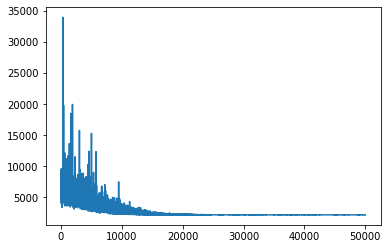

In [3]:
with model:
    approximation = pm.fit(50000,method='advi')#50000 are the number of iterations of the algorithms
#we check the convergence
plt.plot(approximation.hist);

In [ ]:
posterior = approximation.sample(5000)#we sample 5000 samples from the posterior

In [ ]:
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xtestn.T)
y_pred_BLR=np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE=",(np.mean(abs(y_pred_BLR-ytest_price))))
print("MAPE=",(np.mean(abs(y_pred_BLR-ytest_price)/ytest_price)))

## Clustering

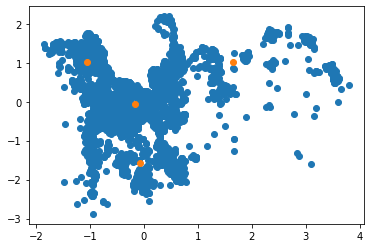

In [4]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4)
#we cluster by lat and long
ind=[3,4]
XX=np.vstack([Xn[:,ind],Xtestn[:,ind]])
XX=np.vstack([Xn[:,ind],Xtestn[:,ind]])
gmm.fit(XX)
plt.scatter(XX[:,0],XX[:,1])
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

clusters_ind = gmm.predict(Xn[:,ind])
clusters_ind_te = gmm.predict(Xtestn[:,ind])

Xn0=Xn[clusters_ind==0,:]
Xtestn0=Xtestn[clusters_ind_te==0,:]
ylog0=np.log(y[clusters_ind==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0=yscaler0.transform(ylog0)


Xn1=Xn[clusters_ind==1,:]
Xtestn1=Xtestn[clusters_ind_te==1,:]
ylog1=np.log(y[clusters_ind==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1=yscaler1.transform(ylog1)

Xn2=Xn[clusters_ind==2,:]
Xtestn2=Xtestn[clusters_ind_te==2,:]
ylog2=np.log(y[clusters_ind==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2=yscaler2.transform(ylog2)

Xn3=Xn[clusters_ind==3,:]
Xtestn3=Xtestn[clusters_ind_te==3,:]
ylog3=np.log(y[clusters_ind==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3=yscaler3.transform(ylog3)

## Piecewise Model

In [5]:
with pm.Model() as model0:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])#we have a beta for each column of Xn
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, Xn0.T)#linear regression model in matrix form
    #likelihood
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])# be sure that observed is a 1d vector
    
with model0:
    approximation = pm.fit(40000,method='advi')#50000 are the number of iterations of the algorithms
    
posterior0 = approximation.sample(5000)#we sample 5000 samples from the posterio



with pm.Model() as model1:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])#we have a beta for each column of Xn
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, Xn1.T)#linear regression model in matrix form
    #likelihood
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])# be sure that observed is a 1d vector
    
with model1:
    approximation = pm.fit(40000,method='advi')#50000 are the number of iterations of the algorithms
    
posterior1 = approximation.sample(5000)#we sample 5000 samples from the posterior



with pm.Model() as model2:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])#we have a beta for each column of Xn
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, Xn2.T)#linear regression model in matrix form
    #likelihood
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])# be sure that observed is a 1d vector
    
with model2:
    approximation = pm.fit(40000,method='advi')#50000 are the number of iterations of the algorithms
    
posterior2 = approximation.sample(5000)#we sample 5000 samples from the posterior

with pm.Model() as model3:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])#we have a beta for each column of Xn
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
    #likelihood
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])# be sure that observed is a 1d vector
    
with model3:
    approximation = pm.fit(40000,method='advi')#50000 are the number of iterations of the algorithms
    
posterior3 = approximation.sample(5000)#we sample 5000 samples from the posterior

    

Average Loss = 1,140.3: 100%|██████████| 40000/40000 [00:11<00:00, 3543.63it/s]
Finished [100%]: Average Loss = 1,140.3
Average Loss = 291.62: 100%|██████████| 40000/40000 [00:10<00:00, 3906.07it/s]
Finished [100%]: Average Loss = 291.61
Average Loss = 315.13: 100%|██████████| 40000/40000 [00:09<00:00, 4068.09it/s]
Finished [100%]: Average Loss = 315.12
Average Loss = 416.13: 100%|██████████| 40000/40000 [00:09<00:00, 4301.04it/s]
Finished [100%]: Average Loss = 416.14


In [6]:
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred



## Only Cluster 0

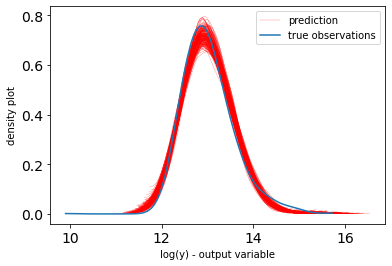

In [7]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Only Cluster 1

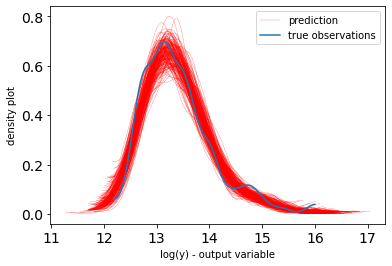

In [8]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Only Cluster 2

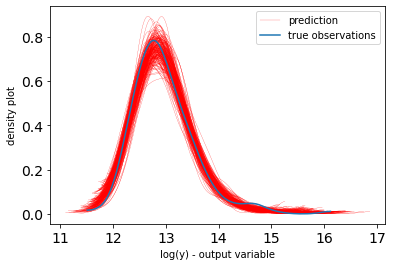

In [9]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Only Cluster 3

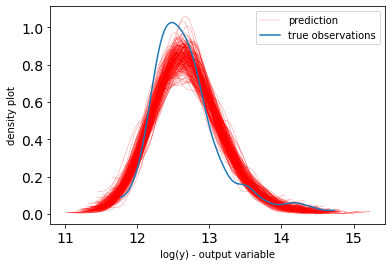

In [10]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

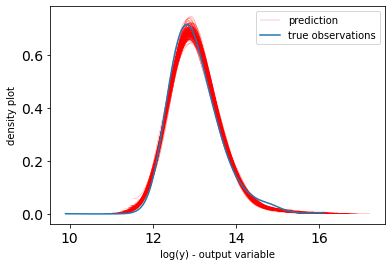

In [11]:
#Simulation
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)
Ypred=np.hstack([ yscaler0.inverse_transform(Ypred0),yscaler1.inverse_transform(Ypred1),yscaler2.inverse_transform(Ypred2),yscaler3.inverse_transform(Ypred3)])
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [14]:
y_pred_BLR0=np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
y_pred_BLR1=np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
y_pred_BLR2=np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
y_pred_BLR3=np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))

print("Size Cluster0", np.sum(clusters_ind_te==0), ", MAE Cluster0=",(np.mean(abs(y_pred_BLR0-ytest_price[clusters_ind_te==0]))))
print("Size Cluster1", np.sum(clusters_ind_te==1), ", MAE Cluster1=",(np.mean(abs(y_pred_BLR1-ytest_price[clusters_ind_te==1]))))
print("Size Cluster2", np.sum(clusters_ind_te==2), ", MAE Cluster2=",(np.mean(abs(y_pred_BLR2-ytest_price[clusters_ind_te==2]))))
print("Size Cluster3", np.sum(clusters_ind_te==3), ", MAE Cluster3=",(np.mean(abs(y_pred_BLR3-ytest_price[clusters_ind_te==3]))))
joint=np.hstack([abs(y_pred_BLR0-ytest_price[clusters_ind_te==0]),abs(y_pred_BLR1-ytest_price[clusters_ind_te==1]),abs(y_pred_BLR2-ytest_price[clusters_ind_te==2]),abs(y_pred_BLR3-ytest_price[clusters_ind_te==3])])

print("MAE=",np.mean(joint))

Size Cluster0 258 , MAE Cluster0= 204001.0209407581
Size Cluster1 81 , MAE Cluster1= 202239.63626064925
Size Cluster2 85 , MAE Cluster2= 216183.96071307614
Size Cluster3 66 , MAE Cluster3= 144075.21625097282
MAE= 197751.5813734773


### PPC on the Test set



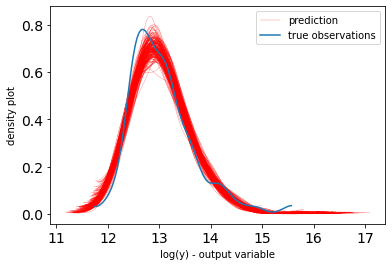

In [13]:
#Simulation
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3,  nsamples=200)
Ypred=np.hstack([ yscaler0.inverse_transform(Ypred0),yscaler1.inverse_transform(Ypred1),yscaler2.inverse_transform(Ypred2),yscaler3.inverse_transform(Ypred3)])
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([10,20])

az.plot_dist(np.log(ytest_price),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");